In [1]:
from transformers import AutoTokenizer

model_ckpt = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [2]:
def tokenize(examples):
    if 'text' in examples:
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    return tokenizer(examples, padding='max_length', truncation=True)

In [3]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [4]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    del inputs
    torch.cuda.empty_cache()

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [39]:
from datasets import Dataset, DatasetDict
import pandas as pd
DatasetDict({'train': Dataset.from_pandas(pd.read_csv('../datasets/disaster_tweets/train.csv'))})

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 7613
    })
})

In [5]:
from datasets import load_dataset
train_set = load_dataset("csv", data_files='../datasets/disaster_tweets/train.csv')
train_set = train_set['train'].train_test_split(test_size=0.2)
test_set = load_dataset("csv", data_files='../datasets/disaster_tweets/test.csv')

In [6]:
train_encoded = train_set.map(tokenize, batched=True, batch_size=None)
test_encoded = test_set.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [7]:
train_encoded.set_format("torch", columns=["input_ids", "attention_mask", "target"])
test_encoded.set_format("torch", columns=["input_ids", "attention_mask"])

In [8]:
train_hidden = train_encoded.map(extract_hidden_states, batched=True, batch_size=8)
test_hidden = test_encoded.map(extract_hidden_states, batched=True, batch_size=8)
# test_hidden
# train_hidden

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [10]:
import numpy as np

X_train = np.array(train_hidden["train"]["hidden_state"])
X_valid = np.array(train_hidden["test"]["hidden_state"])
y_train = np.array(train_hidden["train"]["target"])
y_valid = np.array(train_hidden["test"]["target"])
X_test = np.array(test_hidden["train"]["hidden_state"])
X_train.shape, X_valid.shape

((6090, 768), (1523, 768))

In [10]:
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

2024-02-19 16:53:50.230391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:53:50.366332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-19 16:53:50.366352: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-19 16:53:50.392380: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 16:53:50.939574: W tensorflow/stream_executor/platform/de

,X,Y,label
0,11.730927,8.627548,1
1,13.511849,4.913822,0
2,13.728502,9.707545,1
3,11.674476,7.080075,0
4,13.421262,9.117598,0


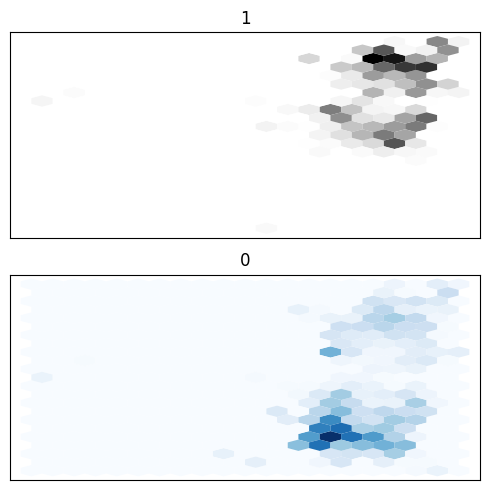

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues"]
labels = train_set["train"].features["target"]
labels = [1, 0]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = [1, 0]
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

# y_preds = lr_clf.predict(X_valid)
# plot_confusion_matrix(y_preds, y_valid, labels)

In [12]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

# model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(train_encoded["train"]) // batch_size
model_name = f"./{model_ckpt}_"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=1e-5,
                                  per_gpu_train_batch_size=batch_size,
                                  per_gpu_eval_batch_size=batch_size,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

2024-02-19 16:58:49.848458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:58:50.096071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-19 16:58:50.096097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-19 16:58:50.135997: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 16:58:50.886982: W tensorflow/stream_executor/platform/de

In [16]:
from transformers import Trainer

train_encoded = train_encoded.rename_column("target", "label")
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded["train"],
                  eval_dataset=train_encoded["test"],
                  tokenizer=tokenizer)
trainer.train()
# try:
#     trainer.train()
# except:
#     del trainer
#     torch.cuda.empty_cache()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479500,0.426104,0.823375,0.822479
2,0.355200,0.473230,0.821405,0.820786


TrainOutput(global_step=1524, training_loss=0.41709744844223884, metrics={'train_runtime': 863.0215, 'train_samples_per_second': 14.113, 'train_steps_per_second': 1.766, 'total_flos': 3204692654284800.0, 'train_loss': 0.41709744844223884, 'epoch': 2.0})

In [17]:
preds_output = trainer.predict(test_encoded['train'])
y_preds = np.argmax(preds_output.predictions, axis=1)
np.unique(y_preds, return_counts=True)

(array([0, 1]), array([1969, 1294]))

In [31]:
y_preds

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
import pandas as pd

df_pandas = pd.DataFrame(test_set['train'])
df_pandas['target'] = y_preds

In [35]:
df_pandas[['id', 'target']].to_csv('submission.csv', index=False)